<a href="https://colab.research.google.com/github/nlei1/csvs-for-proj/blob/main/Copie_de_6_s898_Fall_2022_hw5_generative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install einops
!pip install denoising_diffusion_pytorch

from denoising_diffusion_pytorch import Unet
from inspect import isfunction
from einops import rearrange
from functools import partial
from torch import nn, einsum
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data.dataloader as dataloader
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm import tqdm
import random
import math

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.1/819.1 kB 9.9 MB/s eta 0:00:00


# Fashion MNIST
This dataset is very similar to MNIST, but instead of 10 digits we have 10 types of clothing. For this pset, the labels are not important, and we are only trying to sample from the data distribution $p_\texttt{data}$. Because we are now in the regime of unsupervised learning, we will only use the 60k datapoint training data and disregard the test data.

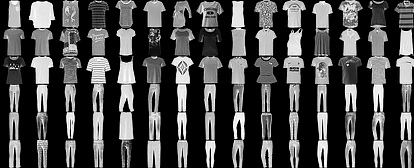

In [2]:
SEED = 1
BATCH_SIZE = 128
NUM_EPOCHS = 20
LR = 1e-3

device = torch.device("cuda")
train = FashionMNIST('./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
train_loader = dataloader.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 10630993.30it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 207021.43it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3742584.78it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20622996.17it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# VAE Architecture
Typically VAEs that operate on images use convolutions and deconvolutions, but in this problem we will simply flatten the input and use an MLP.

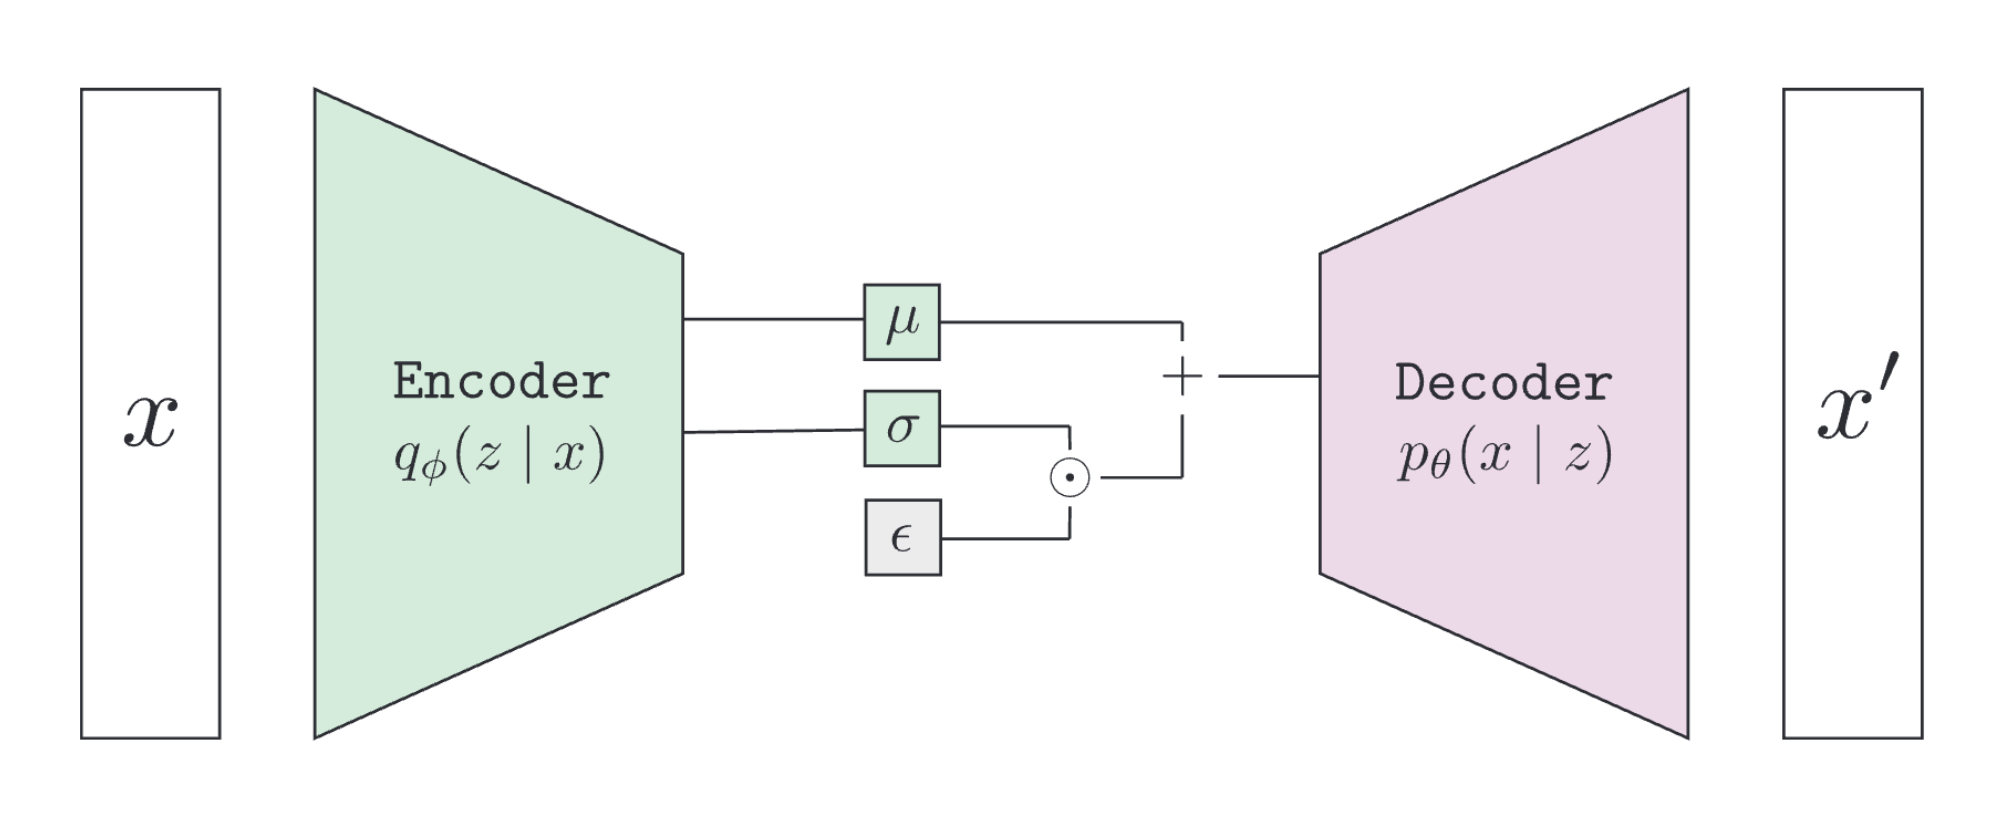

**Question 4:** Implement the VAE architecture
- Inside the `__init__` function you will need to create an four modules.
 - The `encoder` module should have two layers with each layer having `num_hidden` hidden units. Both layers should use `nn.ReLU` nonlinearities.
 - The `mu` readout module and `logvar` readout module should be a single linear layer with no nonlinearities that maps from `num_hidden` units to `z_dims` units. `z_dims` is the size of the latent representation.
 - The `decoder` module should have three layers. The first two layers should have `num_hidden` hidden units and `nn.ReLU` nonlinearities, and the last layer should map to the input size and use a `nn.Sigmoid` nonlinearity.  

- The `forward` function is where you should pass your data through those modules according to the figure above. The output of this function should be a 3-tuple containing the reconstructed image, the mean from the `mu` readout module, and the log of the variance from the `logvar` readout module.
  - HINT 1: To create the z that you pass into the decoder, you will need to sample from a zero-mean unit variance gaussian $\epsilon$ with `torch.randn_like`. You latent should be a transformation of that sample as follows:
  $$z=\mu+\sigma\epsilon. $$
This is typically referred to as the "reparameterization trick."
  - HINT 2: For stability during training, the `logvar` readout module does not output the standard deviation directly, but the log of the variance. You will need to transform appropriately when sampling z.

In [9]:
class VAE(nn.Module):
    def __init__(self, z_dims=4, input_size = 784, num_hidden=128):
        super().__init__()
        self.z_dims = z_dims
        self.input_size = input_size

        # FIXME: Create two encoder layers
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, num_hidden),  # input layer
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),  # hidden layer
            nn.ReLU()
        )

        # FIXME: Create the mean and logvar readout layers
        self.mu = nn.Linear(num_hidden, z_dims) # mean layer
        self.logvar = nn.Linear(num_hidden, z_dims) # logvar layer

        # FIXME: Create the decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(z_dims, num_hidden),  # input layer
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),  # hidden layer
            nn.ReLU(),
            nn.Linear(num_hidden, input_size),  # output layer
            nn.Sigmoid(),
        )

    def forward(self, x):
        # FIXME: Implement the VAE forward function
        encoded = self.encoder(x)
        mu, logvar = self.mu(encoded), self.logvar(encoded)
        return self.decoder(mu + torch.exp(logvar / 2) * torch.randn_like(mu)).view(x.shape), mu, logvar

**Question 5:** Train the VAE. A lot of the code for training the VAE is given. You only need to come up with the $\mathcal{L}_{\text{ELBO}}$ loss given `x_prime`, `mu`, and `logvar`.
  - HINT: The KL Divergence between two gaussians $q_1=\mathcal{N}(\mu_1,\sigma_1)$ and $q_2=\mathcal{N}(\mu_2,\sigma_2)$ is defined as follows:

  $$ D_{\text{KL}}(q_1 \parallel q_2) = log\Big(\frac{\sigma_2}{\sigma_1}\Big) + \frac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-\frac{1}{2}$$


In [52]:
model = VAE().cuda()
optimizer = optim.Adam(model.parameters(), lr=LR)

for epoch in range(NUM_EPOCHS):
  model.train()
  train_loss = 0
  for (X, _) in tqdm(train_loader):
      X = X.cuda()
      optimizer.zero_grad()
      x_prime, mu, logvar = model(X)

      # FIXME: Calculate loss
      loss = None
      loss = F.mse_loss(x_prime, X, reduction='sum') -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar))
      loss.backward()
      train_loss += loss.item()
      optimizer.step()

  print('Epoch: {} Train Loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))

100%|██████████| 469/469 [00:08<00:00, 54.15it/s]


Epoch: 0 Train Loss: 42.7307


100%|██████████| 469/469 [00:09<00:00, 49.09it/s]


Epoch: 1 Train Loss: 29.2384


100%|██████████| 469/469 [00:09<00:00, 50.40it/s]


Epoch: 2 Train Loss: 27.7789


100%|██████████| 469/469 [00:07<00:00, 60.11it/s]


Epoch: 3 Train Loss: 26.6919


100%|██████████| 469/469 [00:09<00:00, 50.11it/s]

Epoch: 4 Train Loss: 26.0001


**Question 6:** Complete the `plot_latents` function such that for a given pair of latent dimensions $(i, j)$ the `plot_latents` plots a grid of images sampled from different pairs of latent values in dimensions $i, j$. Latent dimensions not equal to $i$ or $j$ should be set to zero.

- Hint: You can implement this with a single call to `plt.imshow` by creating a 280x280 image and populating it incrementally with the outputs from `model.decoder(z)` for the different sampled latents z.

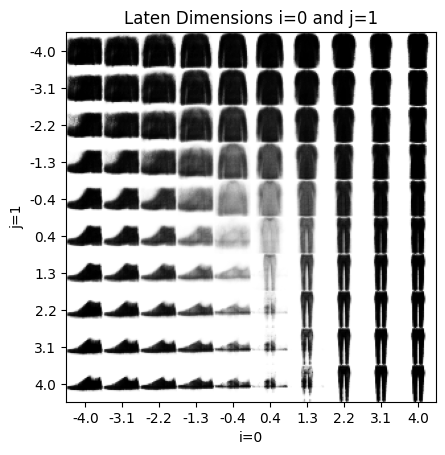

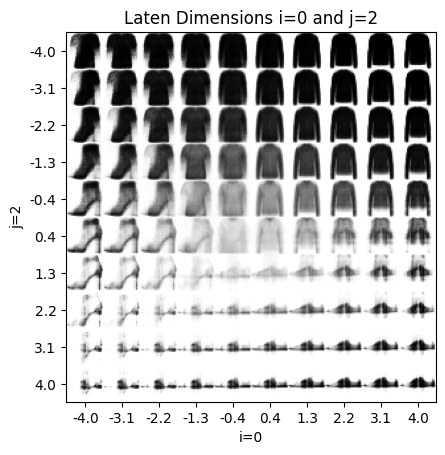

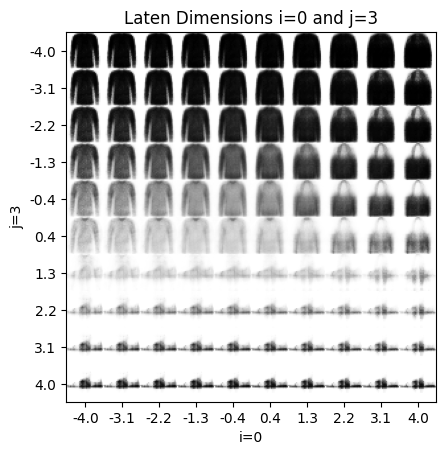

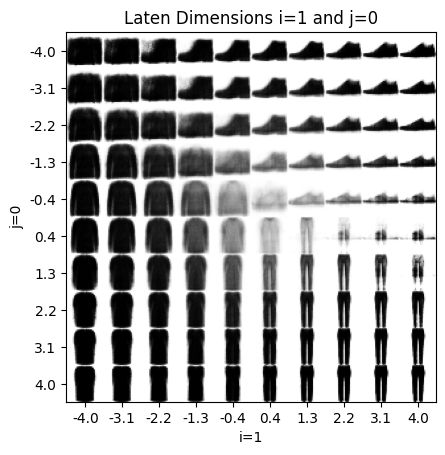

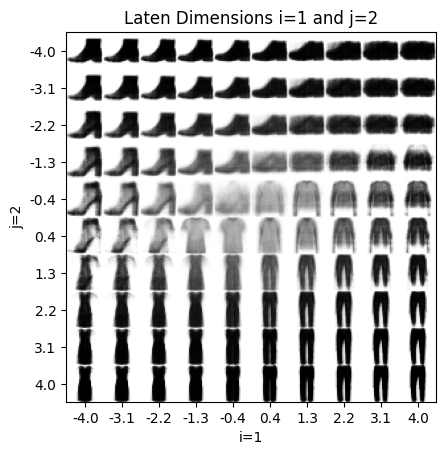

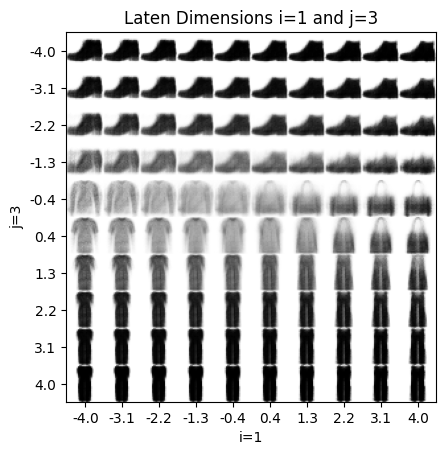

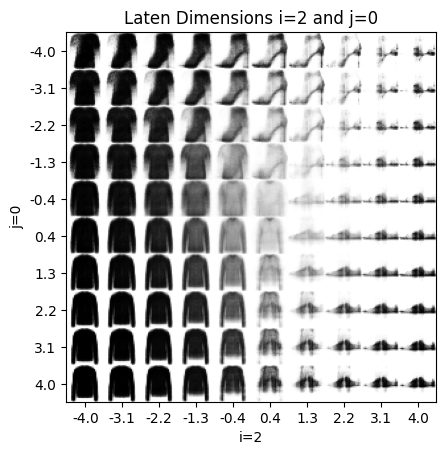

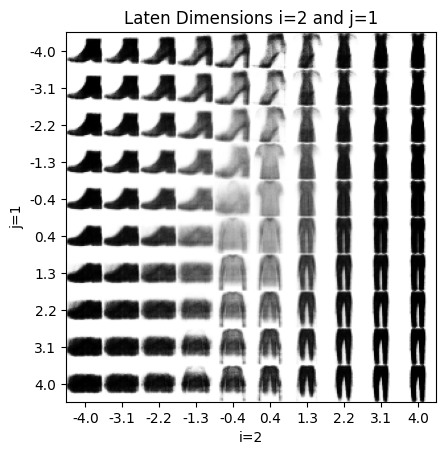

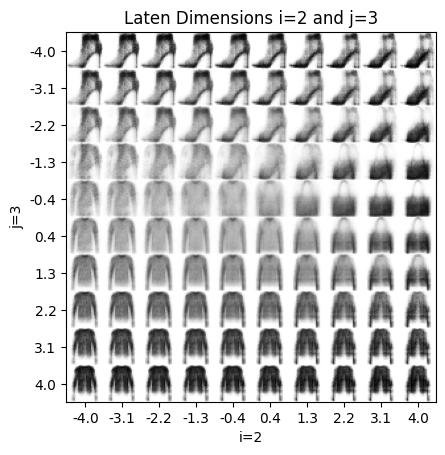

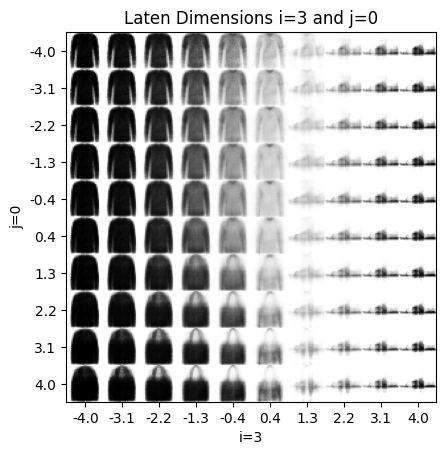

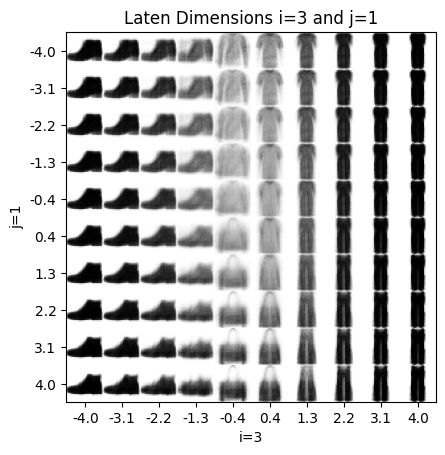

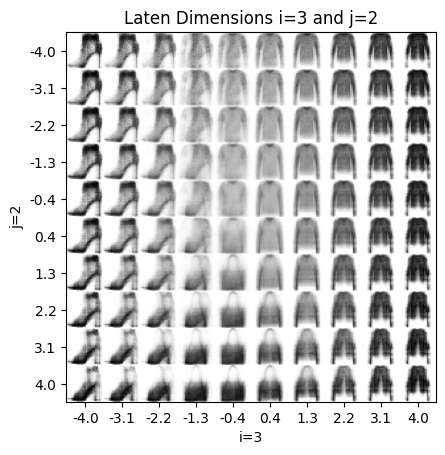

In [55]:
def plot_latents(model, i=0, j=1):
  # FIXME: Plot the image grid
  grid_dim = 10
  img_dim = 28
  model.eval()
  zdims = model.z_dims
  z = torch.zeros(grid_dim, grid_dim, zdims, device=device)
  x = torch.linspace(-zdims, zdims, grid_dim, device=device)
  y = torch.linspace(-zdims, zdims, grid_dim, device=device)
  z[:, :, i] = x.unsqueeze(1).repeat(1, grid_dim)
  z[:, :, j] = y.unsqueeze(0).repeat(grid_dim, 1)
  tmp = model.decoder(z).view(grid_dim, grid_dim, img_dim, img_dim)  # Decode the latent
  images = (tmp.permute(0, 2, 1, 3).reshape(grid_dim * img_dim, -1)).cpu().detach().numpy()

  # Plot
  plt.imshow(images, cmap="binary")  # Plot the image
  plt.xlabel("i=" + str(i))
  plt.ylabel("j=" + str(j))
  ticks = np.arange(img_dim // 2, img_dim * grid_dim + img_dim // 2, img_dim)
  plt.xticks(ticks, x.cpu().numpy().round(1))
  plt.yticks(ticks, y.cpu().numpy().round(1))
  plt.title('Laten Dimensions ' + "i=" + str(i) + ' and ' + "j=" + str(j))

  plt.show()

def plot_zs(model):
  for i in range(model.z_dims):
    for j in range(model.z_dims):
      if i!=j:
        plot_latents(model, i, j)

plot_zs(model)

**Question 7:** Replicate the training procedure from question 5, but using the $\mathcal{L}_{\beta\text{VAE}}$ loss.

Train three networks for $\beta \in \{0.1, 1, 10\}$ and use the `plot_zs` function to visualize the latents.

In [ ]:
# FIXME: Train and visualize for different betas

# Diffusion Models

**Question 11:** Complete the three FIXMEs in the below code.

- NOTE: For each of the FIXMEs in this problem, you are provided with a batch of random times `t`. You will need to index into `beta_t` with this time vector `t` to construct your outputs.

1. Calculate $\textbf{x}_t$ from $\textbf{x}_0$ and $\epsilon\sim\mathcal{N}(0, 1)$ using your equation from question 8. $\textbf{x}_t$ should have the same shape as $\textbf{x}_0$ and $\epsilon$.
2. Using the variance schedule `beta_t`, calculate `beta_tilde_t` using equation 5 from the pset document.
2. Using the variance schedule `beta_t`, calculate `mu_tilde_t` using equation 6 from the pset document. `mu_tilde_t` should have the same shape as `x`.

Your training should take around 2 minutes per epoch

In [47]:
NUM_EPOCHS = 5
TOTAL_TIMESTEPS = 200
scaled_size = 32

# Create the Unet model
model = Unet(scaled_size, channels=1, dim_mults=(1, 2, 4,)).to(device)

# We will use the following variance schedule for our diffusion model
beta_t = torch.linspace(0.0001, 0.02, TOTAL_TIMESTEPS).cuda() # Put on GPU

alpha_t = 1 - beta_t
alpha_bar_t = torch.cumprod(alpha_t, dim=0, dtype=torch.float)

def forward_sample(x_0, t, e):
    # FIXME: calculate x_t from x_0, e, and t using your equation from question 8
    return x_0 * torch.sqrt(alpha_bar_t[t]).view(-1, 1, 1, 1) + torch.sqrt(1 - alpha_bar_t[t]).view(-1, 1, 1, 1) * e


optimizer = optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(NUM_EPOCHS):
    train_losses = []
    for (X, y) in tqdm(train_loader):
      optimizer.zero_grad()
      batch_size = X.shape[0]
      batch = X.to(device)

      # Sample a batch of times for training
      t = torch.randint(0, TOTAL_TIMESTEPS, (batch_size,), device=device).long()

      # Calculate the loss
      e = torch.randn_like(batch)
      x_t = forward_sample(batch, t, e)
      e_pred = model(x_t, t)
      loss = F.mse_loss(e, e_pred)

      # Gradient step
      train_losses.append(loss.item())
      loss.backward()
      optimizer.step()

    print("Epoch: {} Loss: {}".format(epoch, np.mean(train_losses)))

100%|██████████| 469/469 [01:15<00:00,  6.18it/s]


Epoch: 0 Loss: 0.10464992752270912


100%|██████████| 469/469 [01:17<00:00,  6.08it/s]


Epoch: 1 Loss: 0.06260439531921323


100%|██████████| 469/469 [01:15<00:00,  6.19it/s]


Epoch: 2 Loss: 0.05667660247955495


100%|██████████| 469/469 [01:20<00:00,  5.84it/s]


Epoch: 3 Loss: 0.05397193708907821


100%|██████████| 469/469 [01:19<00:00,  5.87it/s]

Epoch: 4 Loss: 0.052175525893598224


## Denoising with the learned model

In [48]:
def reverse_sample(model, x, t):
    t = torch.tensor([t], dtype=torch.int, device=device)
    beta_tilde_t = beta_t[t] * (1 - alpha_bar_t[t-1]) / (1 - alpha_bar_t[t])
    mu_tilde_t = (x - (beta_t[t] * model(x, t)) / torch.sqrt(1 - alpha_bar_t[t])) / torch.sqrt(alpha_t[t])

    e = torch.randn_like(x)
    return mu_tilde_t + torch.sqrt(beta_tilde_t) * e

@torch.no_grad()
def sample(model):
    shape = (1, 1, scaled_size, scaled_size)
    img = torch.randn(shape, device=device)
    imgs = [img.cpu().numpy()]
    for i in reversed(range(0, TOTAL_TIMESTEPS)):
        img = reverse_sample(model, img, i)
        imgs.append(img.cpu().numpy())
    return imgs

**Question 12**
Use the calculated `samples` to visualize the model the diffusion model inference over time.  Create a plot with six horizontally-aligned subfigures showing the diffusion model inference $x_t$ for $t\in{\{200, 100, 50, 20, 10, 0\}}$.

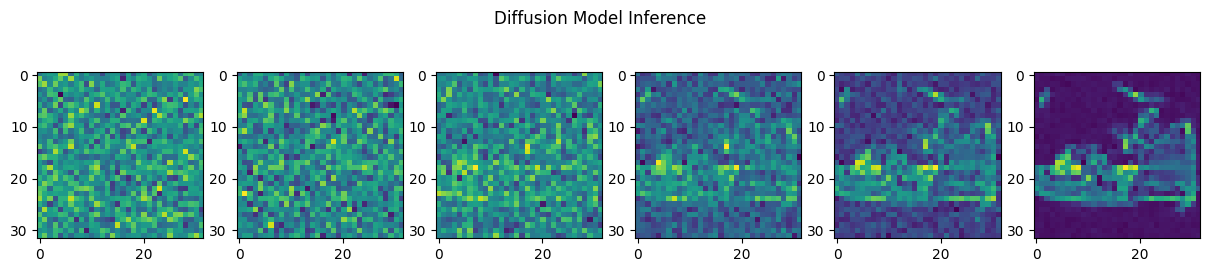

In [50]:
samples = sample(model)
# FIXME: Plot the model inference over time using the samples calculated above
viz_steps = [200, 100, 50, 20, 10, 1]
fig, axes = plt.subplots(1, len(viz_steps), figsize=(15, 3))
fig.suptitle("Diffusion Model Inference")
for i, step in enumerate(viz_steps):
    im = samples[TOTAL_TIMESTEPS - step].reshape(scaled_size, scaled_size)
    axes[i].imshow(im.squeeze())